# **Architecture 3: Transfer Learning on UNET-ResNet with ImageNet weights**

In [1]:
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_tensor,to_pil_image
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset
import torch
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from torch import nn
from torch import optim

In [2]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 88 kB 3.1 MB/s 
     |████████████████████████████████| 376 kB 39.0 MB/s 
     |████████████████████████████████| 58 kB 4.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=dabbf31c0d62f028ddf879a91ce486c6dbc43ce9e43a5c52ef008c4041304c7b
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=ae0dea8524e1d0806ccc57c5578d445690f043968928a034968037f013f11544
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


**Dataset**

In [5]:
class Our_Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform is not None:
          augmented= self.transform(image=np.array(img),
          mask=np.array(mask))
          img = augmented['image']
          mask = augmented['mask']
          mask[mask>11]=0

          img= to_tensor(img)
          mask= torch.from_numpy(mask).type(torch.long)

        return img,mask

In [6]:
TRAIN_IMG_DIR = "Assignment3/images_prepped_train/"
TRAIN_MASK_DIR = "Assignment3/annotations_prepped_train/"
VAL_IMG_DIR = "Assignment3/images_prepped_test/"
VAL_MASK_DIR = "Assignment3/annotations_prepped_test/"

**Data Augmentation**

In [7]:
train_transform = A.Compose(
        [
            A.Resize(height=224, width=224),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
        ],
    )
val_transform = A.Compose(
        [
            A.Resize(height=512, width=512),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
        ],
    )

In [8]:
train_ds=Our_Dataset( image_dir=TRAIN_IMG_DIR,mask_dir=TRAIN_MASK_DIR,
 transform=train_transform)
val_ds=Our_Dataset( image_dir=VAL_IMG_DIR,mask_dir=VAL_MASK_DIR,
 transform=val_transform)

In [9]:
%matplotlib inline
np.random.seed(0)
num_classes=11
COLORS = np.random.randint(0, 2, size=(num_classes+1,
3),dtype="uint8")

**Helper Function to visulaize images and mask**

In [10]:
def show_img_target(img, target):
    if torch.is_tensor(img):
      img=to_pil_image(img)
      target=target.numpy()
    for ll in range(num_classes):
      mask=(target==ll)
      img=mark_boundaries(np.array(img),mask,outline_color=COLORS[ll],color=COLORS[ll])
    plt.imshow(img)

def re_normalize (x, mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]):
   x_r= x.clone()
   for c, (mean_c, std_c) in enumerate(zip(mean, std)):
     x_r [c] *= std_c
     x_r [c] += mean_c
     return x_r

In [11]:
img, mask = train_ds[13]

**Data Loader**

In [12]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)

**UNET-RESNET**

In [13]:
model = smp.Unet(
    encoder_name="resnet34",       
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=12,                    
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Freezing encoder layers

In [14]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [15]:
from torchsummary import summary

**Summary of UNET-ResNet34 Model**

In [16]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

**Loss Function and Optimizer**

In [17]:
criterion = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3E-4)

**Defining Metrics**

In [18]:
def dice_loss1(input, target):
    smooth = 1.
    input=torch.argmax(input, dim=1)
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth)).item()

In [19]:
def iou(outputs, labels):
    SMOOTH= 1e-6
    outputs=torch.argmax(outputs, dim=1)
    
    intersection = (outputs & labels).float().sum((1, 2)) 
    union = (outputs | labels).float().sum((1, 2))         
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    mean_iou=torch.sum(iou)/4 
    return mean_iou.item()

In [20]:
def metrics_batch(pred, target):
  pred=torch.argmax(pred, dim=1)
  metric=dice_loss1(pred, target)
  return metric

In [21]:
def loss_batch(loss_func, output, target, opt=None):
 loss = loss_func(output, target)

 with torch.no_grad():
        metric_b=dice_loss1(output, target)
        iou_score=iou(output,target)

 if opt is not None:
   opt.zero_grad()
   loss.backward()
   opt.step()
 return loss.item(), metric_b,iou_score

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5,
patience=20,verbose=1)

In [23]:
def get_lr(opt):
 for param_group in opt.param_groups:
   return param_group['lr']
current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [24]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
 running_loss=0.0
 running_metric=0.0
 running_iou=0.0
 len_data=len(dataset_dl.dataset)
 for xb, yb in dataset_dl:
   output=model(xb)
   loss_b, metric_b,iou_score = loss_batch(loss_func, output, yb, opt)
   running_loss += loss_b

   if metric_b is not None:
     running_metric+=metric_b
     if iou_score is not None:
      running_iou+=metric_b
   if sanity_check is True:
     break
 loss=running_loss/float(len_data)
 metric=running_metric/float(len_data)
 iou=running_iou/float(len_data)
 return loss, metric,iou

In [25]:
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}
    iou_history={
        "train": [],
        "val": []}  
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric,train_iou=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        iou_history["train"].append(train_iou)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric,val_iou=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        iou_history["val"].append(val_iou)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        print("train loss: %.6f" %(train_loss))
        print("val loss: %.6f" %(val_loss))
        print("-"*10) 
        print(f"Trainig Dice Score {train_metric}")
        print(f"Validation Dice Score {val_metric}")
        print(f"Trainig IOU Score {train_iou}")
        print(f"Validation IOU Score {val_iou}")
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history,iou_history

**Training**

In [26]:
import os
opt = optim.Adam(model.parameters(), lr=1e-6)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": criterion,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"sanity_weights_resnet_transfer.pt",
}

model, loss_hist,metric_his,iou_his = train_val(model, params_train)

Epoch 0/99, current lr=1e-06
Copied best model weights!
train loss: 1592.946356
val loss: 55982.965347
----------
Trainig Dice Score 0.010000905159058947
Validation Dice Score 0.038178753144670244
Trainig IOU Score 0.010000905159058947
Validation IOU Score 0.038178753144670244
Epoch 1/99, current lr=1e-06
Copied best model weights!
train loss: 1569.506812
val loss: 54936.381188
----------
Trainig Dice Score 0.008994400663661696
Validation Dice Score 0.03705891288153016
Trainig IOU Score 0.008994400663661696
Validation IOU Score 0.03705891288153016
Epoch 2/99, current lr=1e-06
Copied best model weights!
train loss: 1539.157357
val loss: 54128.257426
----------
Trainig Dice Score 0.00962641258655517
Validation Dice Score 0.03608817393236821
Trainig IOU Score 0.00962641258655517
Validation IOU Score 0.03608817393236821
Epoch 3/99, current lr=1e-06
Copied best model weights!
train loss: 1574.906335
val loss: 53715.896040
----------
Trainig Dice Score 0.009949528229009227
Validation Dice Sc

**Plotting performance measures**

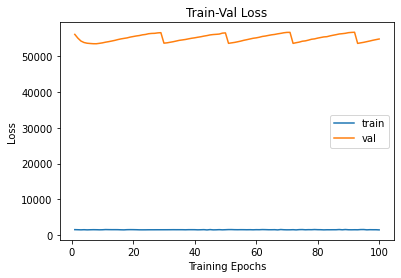

In [27]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

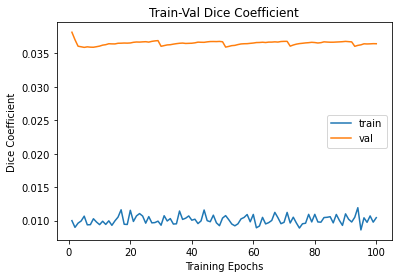

In [28]:
plt.title("Train-Val Dice Coefficient")
plt.plot(range(1,num_epochs+1),metric_his["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_his["val"],label="val")
plt.ylabel("Dice Coefficient")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

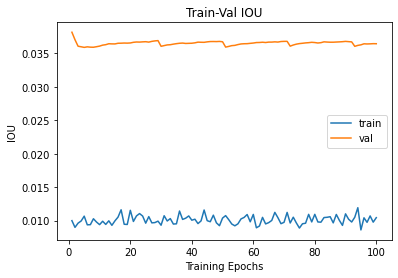

In [29]:
plt.title("Train-Val IOU")
plt.plot(range(1,num_epochs+1),iou_his["train"],label="train")
plt.plot(range(1,num_epochs+1),iou_his["val"],label="val")
plt.ylabel("IOU")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

**Qualitative Results**

In [40]:
img_1, mask_1 = val_ds[77]
img_2, mask_2 = val_ds[11]
img_3, mask_3 = val_ds[53]
img_4, mask_4 = val_ds[92]

In [41]:
def get_prediction(img):
  img=torch.unsqueeze(img, 0)
  prediction=model(img)
  prediction = torch.nn.functional.softmax(prediction, dim=1)
  prediction=torch.squeeze(prediction)
  prediction=torch.argmax(prediction, dim=0)
  return prediction

**Image 1**

In [42]:
pred_1=get_prediction(img_1)

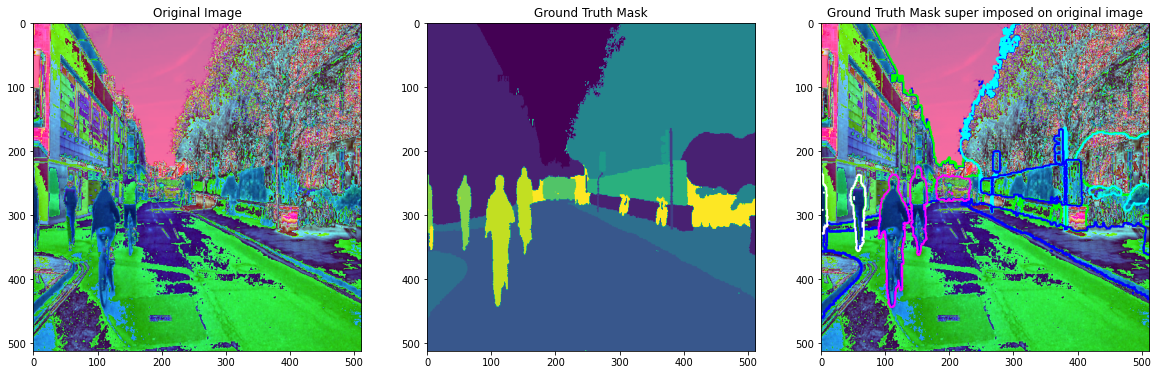

In [43]:
plt.figure(figsize=(20,20))
img_r= re_normalize(img_1)
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_1)
plt.subplot(1, 3, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_1)



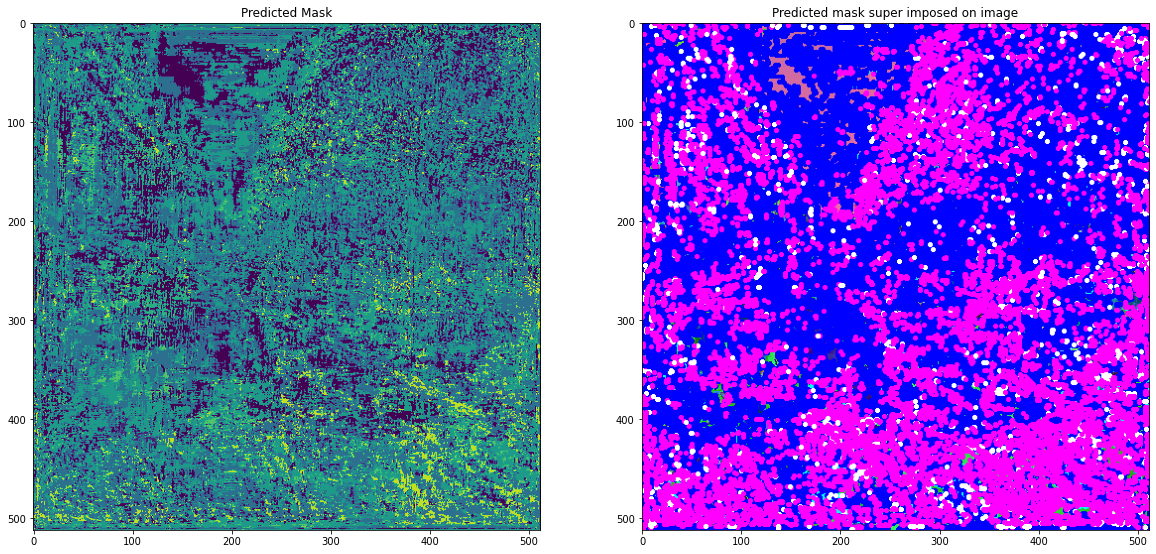

In [45]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_1)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_1)

**Image 2**

In [46]:
pred_2=get_prediction(img_2)

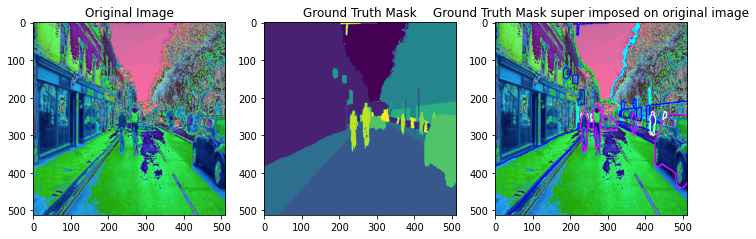

In [47]:
plt.figure(figsize=(20,20))
img_r= re_normalize(img_2)
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 5, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_2)
plt.subplot(1, 5, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_2)


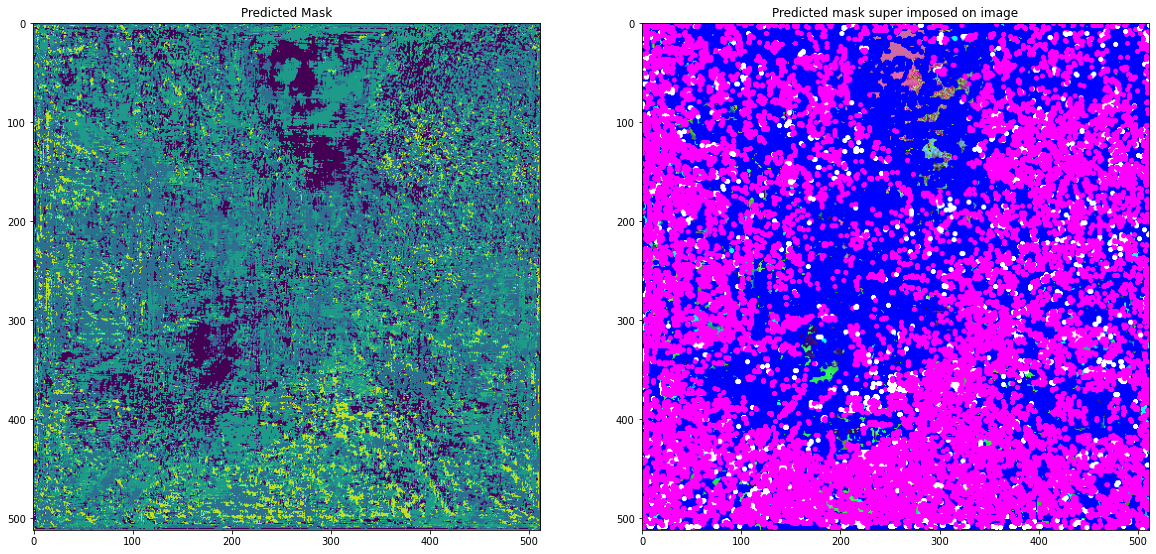

In [56]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_2)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_2)

**Image 3**

In [49]:
pred_3=get_prediction(img_3)

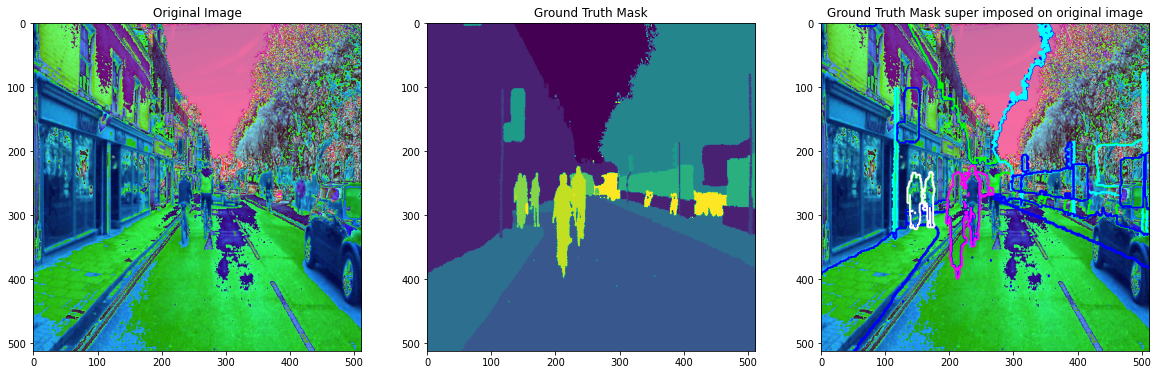

In [50]:
plt.figure(figsize=(20,20))
img_r= re_normalize(img_2)
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_3)
plt.subplot(1, 3, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_3)



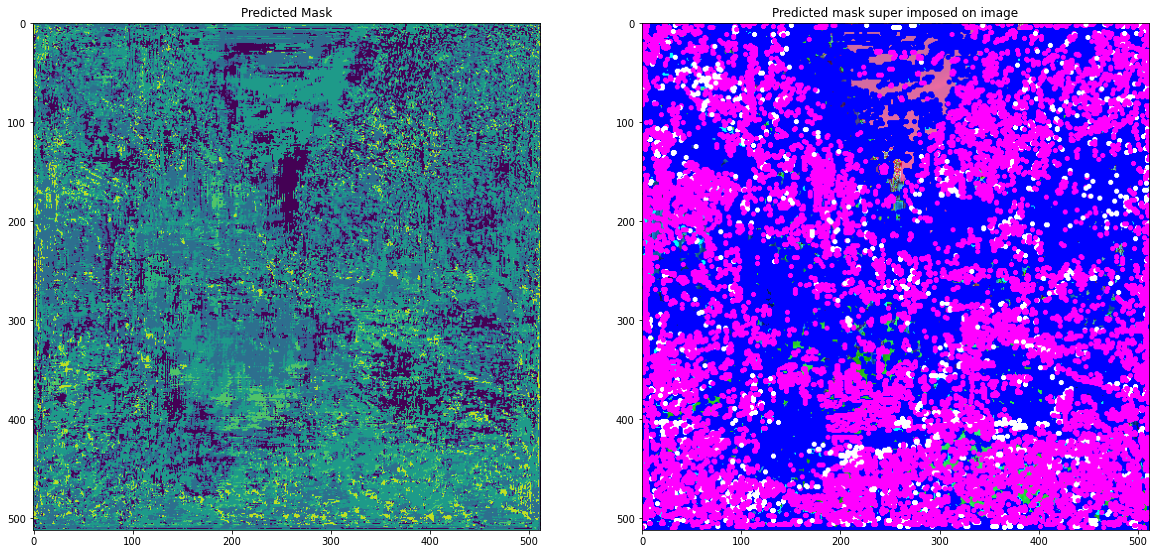

In [51]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_3)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_3)

**Image 4**

In [52]:
pred_4=get_prediction(img_4)

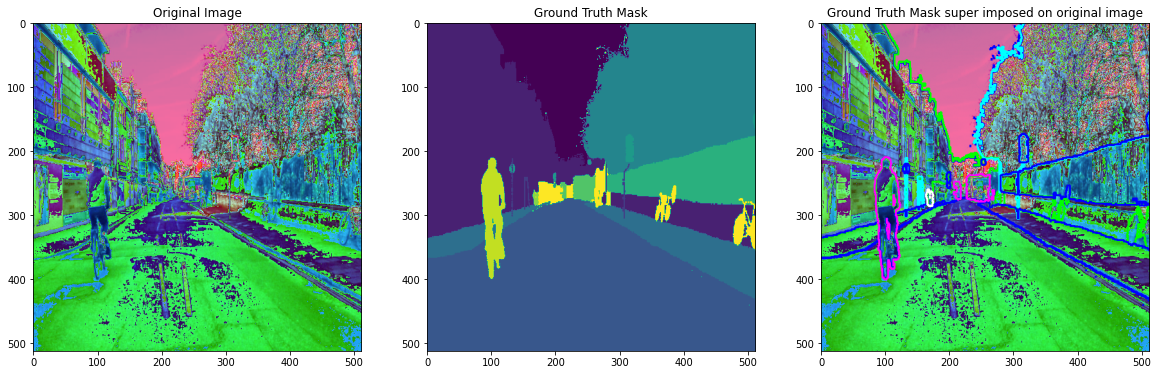

In [53]:
plt.figure(figsize=(20,20))
img_r= re_normalize(img_4)
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_4)
plt.subplot(1, 3, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_4)


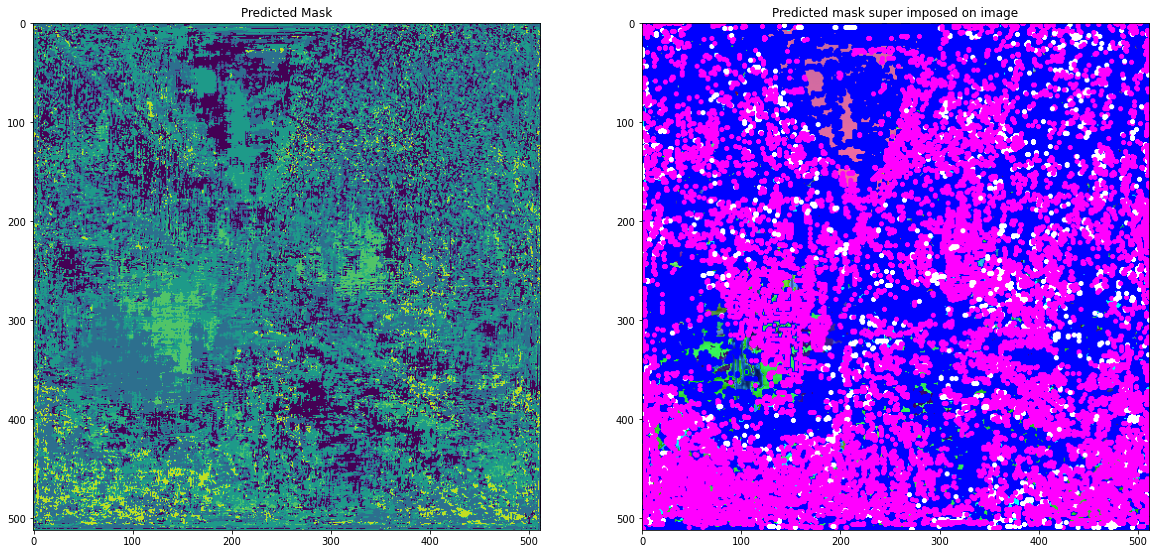

In [54]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_4)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_4)

**Note: Original Image looks distorted in all the above images because of normalization using non-standard mean and standard deviation(0,10. See UNET file to see standard normalized original images.**